### Импортируем библиотеки

In [1]:
import requests
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

### Зададим переменные для парсинга курса валют

In [2]:
start_date = '2023-06-01'
end_date = '2023-06-30'
base = 'BTC'
symbols = 'RUB'
format = 'CSV'

### Создадим переменную ***response*** и запишем в нее ответ сервера. Сохраним результат в формате *.csv.

In [3]:
response = requests.get('https://api.exchangerate.host/timeseries?',
                            params={'base': base,
                                    'start_date': start_date,
                                    'end_date': end_date,
                                    'symbols': symbols,
                                    'format': format
                            })

with open('./csv_files/exchange_june2023.csv', 'wb') as f:
    f.write(response.content)

### Прочитаем полученный файл exchange_june2023.csv средствами Pandas для замены разделителя десятичных знаков с "," на ".", чтобы данные корректно загрузились в базу данных.

In [4]:
df = pd.read_csv('./csv_files/exchange_june2023.csv', decimal=',', index_col=False)
df = pd.DataFrame(df)
df

,date,code,rate,base,start_date,end_date
0,2023-06-01,RUB,2.180140e+06,BTC,2023-06-01,2023-06-30
1,2023-06-02,RUB,2.219636e+06,BTC,2023-06-01,2023-06-30
2,2023-06-03,RUB,2.164137e+06,BTC,2023-06-01,2023-06-30
3,2023-06-04,RUB,2.216854e+06,BTC,2023-06-01,2023-06-30
4,2023-06-05,RUB,2.060827e+06,BTC,2023-06-01,2023-06-30
5,2023-06-06,RUB,2.231097e+06,BTC,2023-06-01,2023-06-30
6,2023-06-07,RUB,2.128601e+06,BTC,2023-06-01,2023-06-30
7,2023-06-08,RUB,2.157652e+06,BTC,2023-06-01,2023-06-30
8,2023-06-09,RUB,2.168827e+06,BTC,2023-06-01,2023-06-30
9,2023-06-10,RUB,2.117741e+06,BTC,2023-06-01,2023-06-30


### Снова сохраним таблицу в файл *.csv.

In [5]:
df.to_csv('./csv_files/exchange_june2023.csv', index=False)

### Создадим подключение к базе Postgres, которую мы развернули в docker-compose:

In [6]:
conn = psycopg2.connect(database='exchange',
                        user='postgres',
                        password='password',
                        host='localhost',
                        port=5434)
cur = conn.cursor()

### Создадим в базе таблицу exchange_june2023.

In [7]:
cur.execute("""
CREATE TABLE exchange_june2023(
    date DATE PRIMARY KEY,
    exchange_id VARCHAR,
    exchange_rate DECIMAL,
    base_exchange VARCHAR,
    start_date DATE,
    end_date DATE
)
""")

### Заполним таблицу данными из файла exchange_june2023.csv

In [8]:
cur.execute("""COPY exchange_june2023
FROM '/docker-entrypoint-initdb.d/csv_files/exchange_june2023.csv'
DELIMITER ','
CSV HEADER;""")
conn.commit()

### Посмотрим, как загрузились данные. Для этого выведем первую строчку таблицы.

In [9]:
cur.execute("""select * from exchange_june2023;""")
print(cur.fetchone())
conn.commit()

(datetime.date(2023, 6, 1), 'RUB', Decimal('2180140.15'), 'BTC', datetime.date(2023, 6, 1), datetime.date(2023, 6, 30))


### Создадим таблицу c результатами по курсу биткоина (BTC):
   - дата максимального значения валюты (date_max_rate);
   - максимальное значение валюты (max_val_rate);
   - дата минимального значения валюты (date_min_rate);
   - минимальное значение валюты (min_val_rate);
   - среднее значение за месяц (avg_rate);
   - курс BTC на последний день месяца (last_date_rate).

In [10]:
cur.execute("""CREATE TABLE result_query AS (SELECT * FROM (SELECT "date" date_max_rate, MAX(exchange_rate) max_val_rate
				FROM exchange_june2023
				WHERE exchange_rate = (SELECT MAX(exchange_rate) FROM exchange_june2023)
				GROUP BY "date") max_rate
CROSS JOIN
	(SELECT "date" date_min_rate, MIN(exchange_rate) min_val_rate
	FROM exchange_june2023
	WHERE exchange_rate = (SELECT MIN(exchange_rate) FROM exchange_june2023)
	GROUP BY "date") min_rate
CROSS JOIN
	(SELECT AVG(exchange_rate) avg_rate FROM exchange_june2023) avg_rate
CROSS JOIN
	(SELECT exchange_rate last_date_rate
						FROM exchange_june2023
						WHERE "date" = '2023-06-30') last_date_rate)
;""")
conn.commit()

### Выведем новую таблицу "result_query" на печать.

In [11]:
cur.execute("""select * from result_query;""")
print(cur.fetchall())
conn.commit()
conn.close ()

[(datetime.date(2023, 6, 30), Decimal('2693520.583333'), datetime.date(2023, 6, 5), Decimal('2060826.642857'), Decimal('2312089.860954800000'), Decimal('2693520.583333'))]


### Вот так наша таблица выглядит в DBeaver'e.

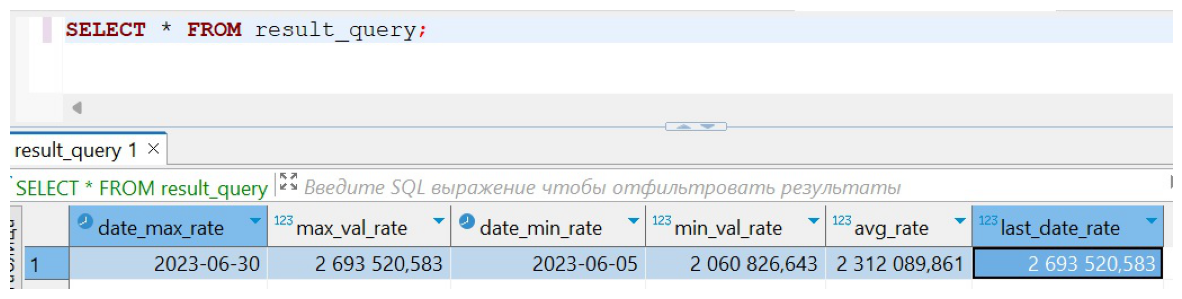

In [12]:
plt.figure(figsize=(15, 30))
plt.axis('off')
image = plt.imread('result_query.jpg')
plt.imshow(image)
plt.show()